# Title

In [13]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from diffusers import DDPMScheduler

from models.unet import UNet
from models.autoencoder import Autoencoder
from models.class_conditioned_unet import ClassConditionedUnet
from utils.evaluate_autoencoder import evaluate_autoencoder
from utils.evaluate_diffusion import evaluate_diffusion_model

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [2]:
# Add noise to the input images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, -1.0, 1.0)  # Keep pixel values in [-1, 1]

In [3]:
# Customowy MNIST z zaszuionymi obrazami
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        #AddNoiseTransform(noise_level=0.2),  # Add noise to the images
    ])
)
train_set, test_set = torch.utils.data.random_split(dataset, [50000, 10000])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True)

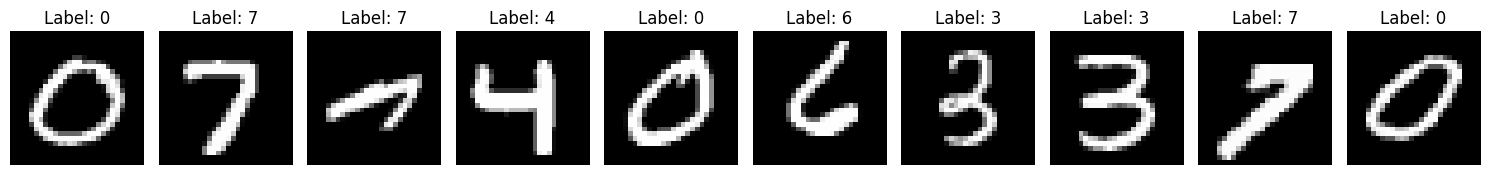

In [4]:
#plot the noisy image
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img, label = train_set[i]  # Get the image and label
    img = img.squeeze(0).numpy()  # Remove channel dimension and convert to numpy
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# Szum (Noise)

![Unet](./images/noise.jpg)
<br>
Szum to dodatkowe informacje, które nie są związane z obiektem obserwowanym. W przypadku obrazów cyfrowych szum to dodatkowe piksele, które nie są częścią obrazu. Mogą być one spowodowane zakłóceniami wynikającymi z konstukcji urządzenia przechwytującego obraz albo parametrów ekspozycji, wysokie ISO i słabe oświetlenie zazwyczaj prowadzą do zwiększenia szumu. Szum może pojawić się również na skutek obróbki obrazu, kompresji albo upscalingu.
<br>
Obecność szumu powoduje spadek jakości obrazu i oraz utratę zawartych w nim informacji, gdyż oryginalne wartości pixeli są zastępowane przez wartości losowe.

### Rodzaje szumu

### Jak zmierzyć szum?
Najczęściej stosowane są dwie metryki (dokładniejsze omówienie na zajęciach 3)
-   Peak Signal to Noise Ratio (PSNR)
-   Structural Similarity Index (SSIM)

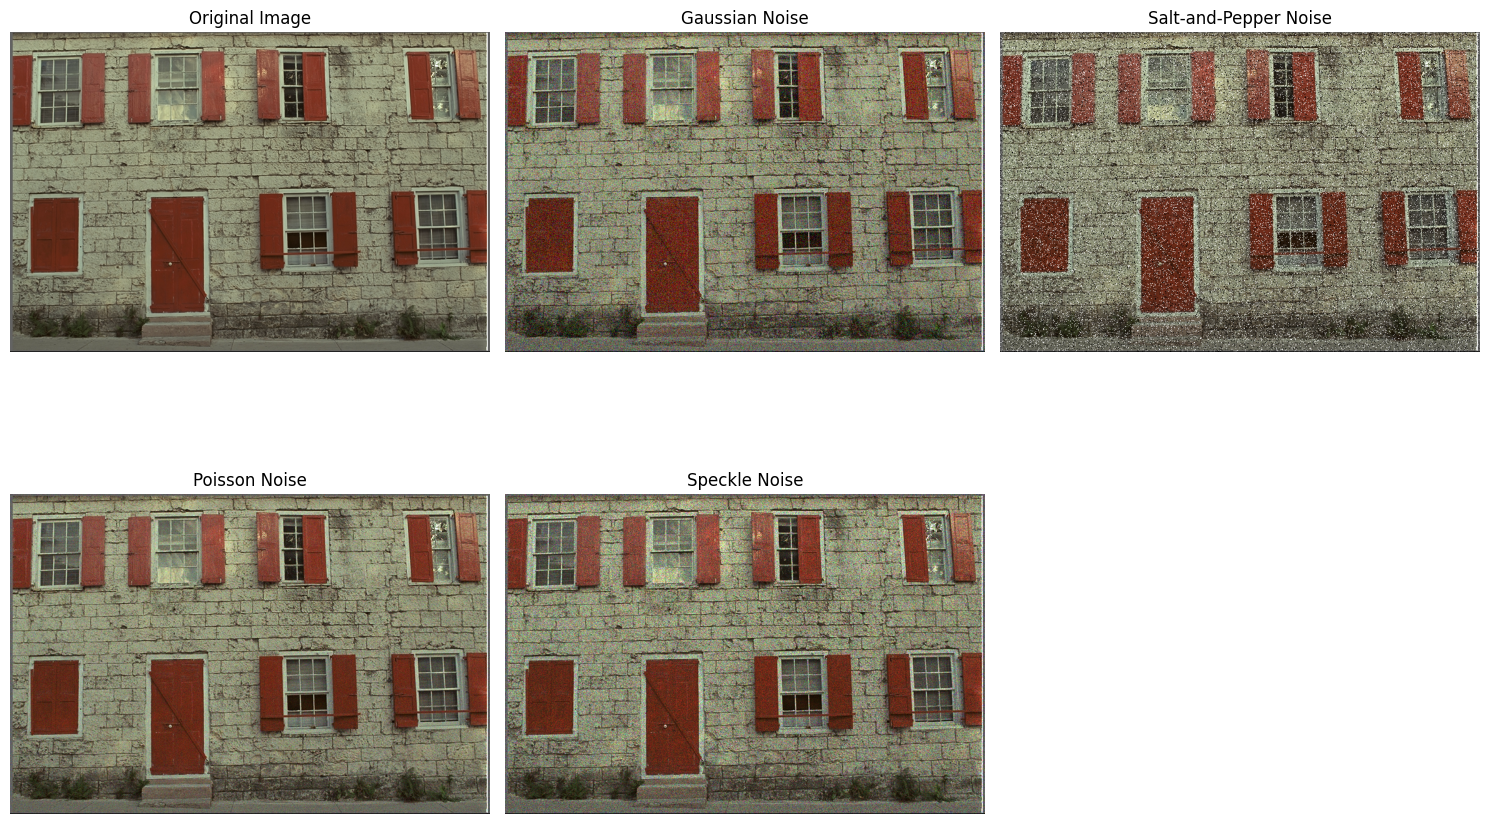

In [5]:
# Open the image
sample_image = Image.open('./data/kodak/kodim01.png')

# Convert the image to a NumPy array
image_array = np.array(sample_image, dtype=np.float32)

# Add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    # Clip the values to be within valid range (0-255 for an image)
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Add Salt-and-Pepper noise
def add_salt_and_pepper_noise(image, amount=0.05):
    noisy_image = image.copy()
    num_salt = int(amount * image.size * 0.5)
    num_pepper = int(amount * image.size * 0.5)

    # Add salt (white pixels)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 255

    # Add pepper (black pixels)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image

# Add Poisson noise
def add_poisson_noise(image):
    noisy_image = np.random.poisson(image).astype(np.float32)
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Add Speckle noise
def add_speckle_noise(image, std=0.2):
    noise = np.random.randn(*image.shape) * std
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Apply different types of noise
noisy_gaussian = add_gaussian_noise(image_array)
noisy_salt_pepper = add_salt_and_pepper_noise(image_array, amount=0.05)
noisy_poisson = add_poisson_noise(image_array)
noisy_speckle = add_speckle_noise(image_array)

# Display the original and noisy images
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Gaussian Noise')
plt.imshow(Image.fromarray(noisy_gaussian.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Salt-and-Pepper Noise')
plt.imshow(Image.fromarray(noisy_salt_pepper.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Poisson Noise')
plt.imshow(Image.fromarray(noisy_poisson.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Speckle Noise')
plt.imshow(Image.fromarray(noisy_speckle.astype(np.uint8)))
plt.axis('off')

plt.tight_layout()
plt.show()


# Odszumianie

W celu odszumiania stosowany jest szeroki zakres metod, począwszy od prostych filtrów Gaussa rozmywających obraz w celu ukrycia szumów bo różnego rodzaju rozwiązania oparte o metody uczenia maszynowego. Pierwszą architekturą szeroko sosowaną do takiego celu były Autoenkodery.

## Autoenkoder

Autoenkodery to modele składające się z dwóch części - enkodera i dekodera. Enkoder koduje wejściowy obraz do reprezentacji ukrytej, z której dekoder jest następnie w stanie "odzyskać" źródłowy obraz. Powoduje to że autoenkodery bardzo dobrze sprawdzają się w scenariuszach kompresji danych.
<br>
<br>
![enc](./images/autoencoder.jpg)<br><br>
Autoenkodery trenujemy minimalizując loss pomiędzy obrazkiem wejściowym a wyjściowym -> chcemy żeby to co jest na wyjściu jak najbardziej przypominało to co jest na wejściu, ale co gdyby spróbować dodac do danych wejściowych szum ale loss dalej liczyć względem odszumionego obrazka?
<br>
<br>
![enc](./images/denoise.jpg)<br><br>
Okazuje się, że po tej niewielkiej modyfikacji autoenkoder zamienia się w model, który całkiem skutecznie odszumia dane !

In [6]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
epochs = 10

Zmodyfikowaliśmy trening autoencodera, tak aby dodać szum do przykładów treningowych, celem jest minimalizowanie kosztu pomiędzy rekonstrukcją obrazu a obrazem odszumionym -> w ten sposób jestesmy w stanie nauczyć autoenkoder odszumiania obrazków.

In [7]:
# Training loop
for epoch in range(epochs):
    model.train()
    for images, _ in train_dataloader:
        # Add noise to the images
        noisy_images = add_noise(images)

        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Compare reconstructed images with clean images

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0673
Epoch [2/10], Loss: 0.0365
Epoch [3/10], Loss: 0.0285
Epoch [4/10], Loss: 0.0223
Epoch [5/10], Loss: 0.0213
Epoch [6/10], Loss: 0.0192
Epoch [7/10], Loss: 0.0180
Epoch [8/10], Loss: 0.0167
Epoch [9/10], Loss: 0.0151
Epoch [10/10], Loss: 0.0141


Sprawdźmy jak poradził sobie model

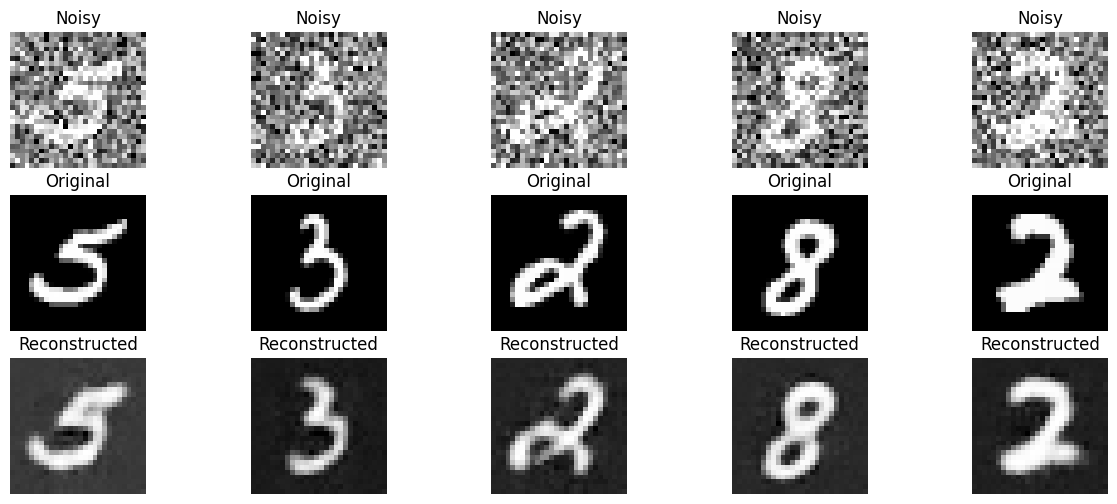

Average PSNR: 24.46
Average SSIM: 0.8006


In [8]:
model.eval()
avg_psnr, avg_ssim = evaluate_autoencoder(model, test_dataloader, add_noise, visualize=True)

Jak widać pomimo znacznego zaszumienia danych wejściowych, autoenkoder dość dobrze poradził sobie z ich odszumieniem.


## Diffusion
https://theaisummer.com/diffusion-models/

Modele dyfuzyjne najbardziej znane są z ich zastosowań generowaia obrazków np. StableDiffusion,
działają na zasadzie systematycznego niszczenia struktury w rozkładzie danych poprzez iteracyjny proces dyfuzji - proces ten nazywamy "Forward diffusion", podczas niego przekształcamy obraz w szum.
<br>
![fwd](./images/forwad_diffusion.jpg)
<br>
Następnie następuje "Reverse diffusion" który ma na celu przekształcenie uzyskanego szumu w obraz.
<br>
![rvd](./images/backward_diffusion.jpg)
<br>
Jak widać takie działanie modelu sugeruje, że sprawdzi się on dobrze przy odszumianiu obrazów

In [9]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
epochs = 20

In [10]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [11]:
# Training loop
losses = []
for epoch in range(epochs):
    for x, _ in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Move data to MPS device
        noise = torch.randn_like(x)
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (x.shape[0],), device=device
        )
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps) # Add noise according to scheduler

        # Get the model prediction
        pred = model(noisy_x)

        # Calculate the loss
        loss = criterion(pred, x)

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Average loss: {avg_loss:05f}")

/Users/jkosciukiewicz/miniconda3/envs/NeuralRendering/lib/python3.12/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch [1/10], Average loss: 0.063084
Epoch [2/10], Average loss: 0.053220
Epoch [3/10], Average loss: 0.051765
Epoch [4/10], Average loss: 0.051008
Epoch [5/10], Average loss: 0.050474
Epoch [6/10], Average loss: 0.049662
Epoch [7/10], Average loss: 0.049471
Epoch [8/10], Average loss: 0.049134
Epoch [9/10], Average loss: 0.048930
Epoch [10/10], Average loss: 0.048575


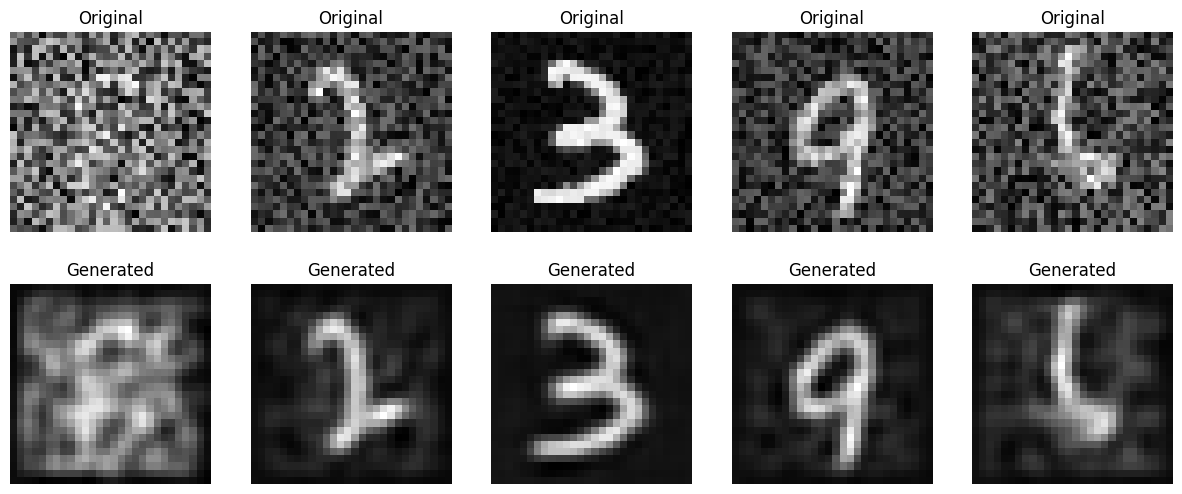

Average PSNR: 20.64
Average SSIM: 0.5658


In [12]:
evaluate_diffusion_model(model, test_dataloader,device,True)

# Modele Generatywne 2D

[opis kategorii]

## Dyfuzja

In [14]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

In [ ]:
n_epochs = 10
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1  # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}")

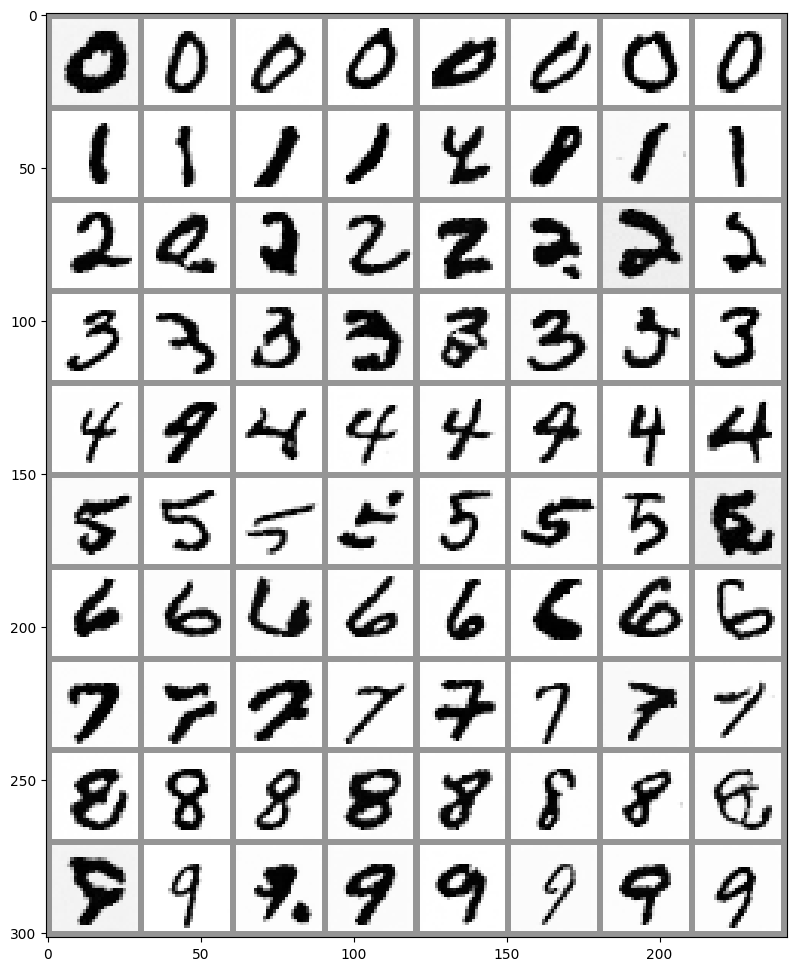

In [16]:
# @markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

## GAN
GAN-y to rodzina modeli generatywnych wykorzystujących metody adwersarialne do generowania nowych obrazków.

In [22]:
from models.gan import Generator,Discriminator

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

epochs=50

In [23]:
 # Training
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, 100, device=device)
        gen_labels = torch.randint(0, 10, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print training progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(train_dataloader)}] "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


Epoch [0/50] Batch [0/391] Loss D: 0.6943, Loss G: 0.7215
Epoch [0/50] Batch [100/391] Loss D: 0.5302, Loss G: 1.2426
Epoch [0/50] Batch [200/391] Loss D: 0.3900, Loss G: 1.7542
Epoch [0/50] Batch [300/391] Loss D: 0.2151, Loss G: 2.5444
Epoch [1/50] Batch [0/391] Loss D: 0.4137, Loss G: 1.0019
Epoch [1/50] Batch [100/391] Loss D: 0.2873, Loss G: 2.7890
Epoch [1/50] Batch [200/391] Loss D: 0.3141, Loss G: 2.4583
Epoch [1/50] Batch [300/391] Loss D: 0.4785, Loss G: 2.5389
Epoch [2/50] Batch [0/391] Loss D: 0.3825, Loss G: 1.9316
Epoch [2/50] Batch [100/391] Loss D: 0.3490, Loss G: 2.5592
Epoch [2/50] Batch [200/391] Loss D: 0.3355, Loss G: 3.3426
Epoch [2/50] Batch [300/391] Loss D: 0.3733, Loss G: 1.1150
Epoch [3/50] Batch [0/391] Loss D: 0.3098, Loss G: 2.9249
Epoch [3/50] Batch [100/391] Loss D: 0.3248, Loss G: 1.9166
Epoch [3/50] Batch [200/391] Loss D: 0.2238, Loss G: 2.6439
Epoch [3/50] Batch [300/391] Loss D: 0.3241, Loss G: 1.4732
Epoch [4/50] Batch [0/391] Loss D: 0.2937, Loss 

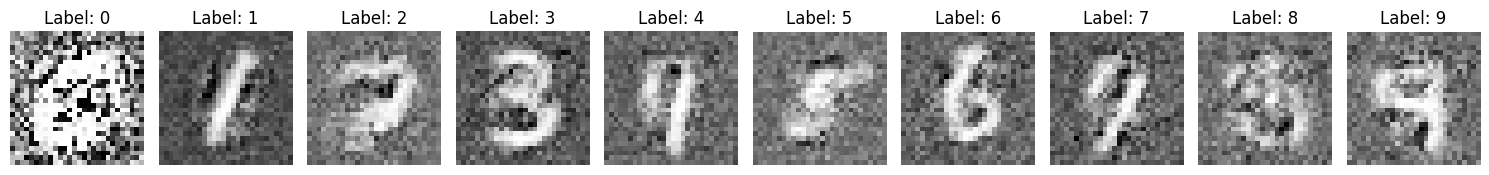

In [24]:
generator.eval()  # Set generator to evaluation mode
with torch.no_grad():
    # Generate noise and random labels
    z = torch.randn(10, 100, device=device)
    labels = torch.arange(0, 10, device=device)  # One image per label
    gen_imgs = generator(z, labels).cpu()

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = (gen_imgs + 1) / 2

    # Plot the images
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(gen_imgs[i, 0], cmap="gray")  # Plot only the first channel
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


## Gany 3D
Modele typu GAN, choć pierwotnie zaprojektowane do generowania obrazów 2D, w połączeniu z technikami volume renderingu, takimi jak NeRF, stają się niezwykle skutecznym narzędziem do modelowania 3D. GANy wykorzystują latent space jako zredukowaną reprezentację danych, która jest mapowana na złożoną strukturę trójwymiarową. Pozwala to na kontrolowanie cech generowanych obiektów, takich jak kształt, tekstura, detale czy styl. Techniki te są szczególnie przydatne w generowaniu realistycznych modeli 3D.

W modelowaniu 3D GANy umożliwiają nie tylko generowanie nowych obiektów, ale także ich manipulację poprzez operacje w przestrzeni latentnej, co otwiera możliwości tworzenia personalizowanych i unikalnych modeli. W połączeniu z metodami, które eliminują konieczność precyzyjnych danych o pozycjach kamery, możliwe jest generowanie realistycznych struktur z szerokiej gamy danych.

#### HyperNeRFGAN
HyperNeRFGAN to przykład połączenia NeRFa z GAN-em w celu stworzenia generatywnego modelu 3D. Generator dostając na wejście wektor cech opisujaych wygląd modelu generuje wagi dla seci NeRF. Nastepnie Dyskryminator "ocenia" dokładność odwzorowania dla każdego wygenerowanego widoku, w ten sposób reprezentacja jest poprawiana, do momentu kiedy model zacznie generować realistyczne obiekty<br>
![nerfgan1](./images/nerfgan.jpg)
![nerfgan2](./images/cars.jpg)<br>
#### Niedeterministyczność
Wadą takich rozwiązań jest to że sa niedeterministyczne - w przypadku zastosowań takich modeli do rekonstrukcji danych np. z brakujacymi położeniami kamery model poradzi sobie dość dobrze, jednak wygenerowana reprezentacja za każdym razem będzie inna. W przypadku zastosowań np. medycznych jest to realny problem, który w połączeniu z bardzo długim czasem treningu oraz podatnością podatność na te same przypadłości co GAN-y (mode collapse itp) raczej dyskwalifikuje te modele z tego scenariusza. <br>
![nerfgan3](./images/knee.gif)<br>
![nerfgan4](./images/lung.gif)
<br>
<br>
